In [76]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import requests 

In [77]:
import pandas_datareader as pdr
import matplotlib.pyplot as plt
#Trade data for West Texas Intermediate 
wti_data = pdr.get_data_yahoo('cl=f', '2-March-19') 
wti_data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-07-09,40.990002,39.270000,40.869999,40.900002,345020.0,40.900002
2020-07-10,40.770000,38.540001,39.580002,39.619999,366208.0,39.619999
2020-07-12,40.529999,39.930000,40.349998,40.220001,640687.0,40.220001
2020-07-13,40.720001,39.470001,40.349998,40.549999,345391.0,40.549999
2020-07-14,40.860001,39.070000,39.189999,40.509998,168385424.0,40.509998


In [78]:
#Moving average crossover strategy
wti_data['9_SMA'] = wti_data['Close'].rolling(window=9).mean()
wti_data['20_SMA'] = wti_data['Close'].rolling(window=50).mean()

wti_data = wti_data[wti_data['20_SMA'].notna()]

# WTI trade Signal
Trade_Entry=[]
Trade_Exit=[]
for i in range(len(wti_data)-1):
    if ((wti_data['9_SMA'].values[i] < wti_data['20_SMA'].values[i]) & (wti_data['9_SMA'].values[i+1] > wti_data['20_SMA'].values[i+1])):
        print("Trade Call for {row} is Entry.".format(row=wti_data.index[i].date()))
        Trade_Entry.append(i)
    elif ((wti_data['9_SMA'].values[i] > wti_data['20_SMA'].values[i]) & (wti_data['9_SMA'].values[i+1] < wti_data['20_SMA'].values[i+1])):
        print("Trade Signal for {row} is Exit.".format(row=wti_data.index[i].date()))
        Trade_Exit.append(i)

Trade Signal for 2019-05-22 is Exit.
Trade Call for 2019-07-09 is Entry.
Trade Signal for 2019-07-23 is Exit.
Trade Call for 2019-08-01 is Entry.
Trade Signal for 2019-08-02 is Exit.
Trade Call for 2019-09-10 is Entry.
Trade Signal for 2019-09-11 is Exit.
Trade Call for 2019-09-13 is Entry.
Trade Signal for 2019-10-02 is Exit.
Trade Call for 2019-10-31 is Entry.
Trade Signal for 2020-01-17 is Exit.
Trade Call for 2020-05-10 is Entry.


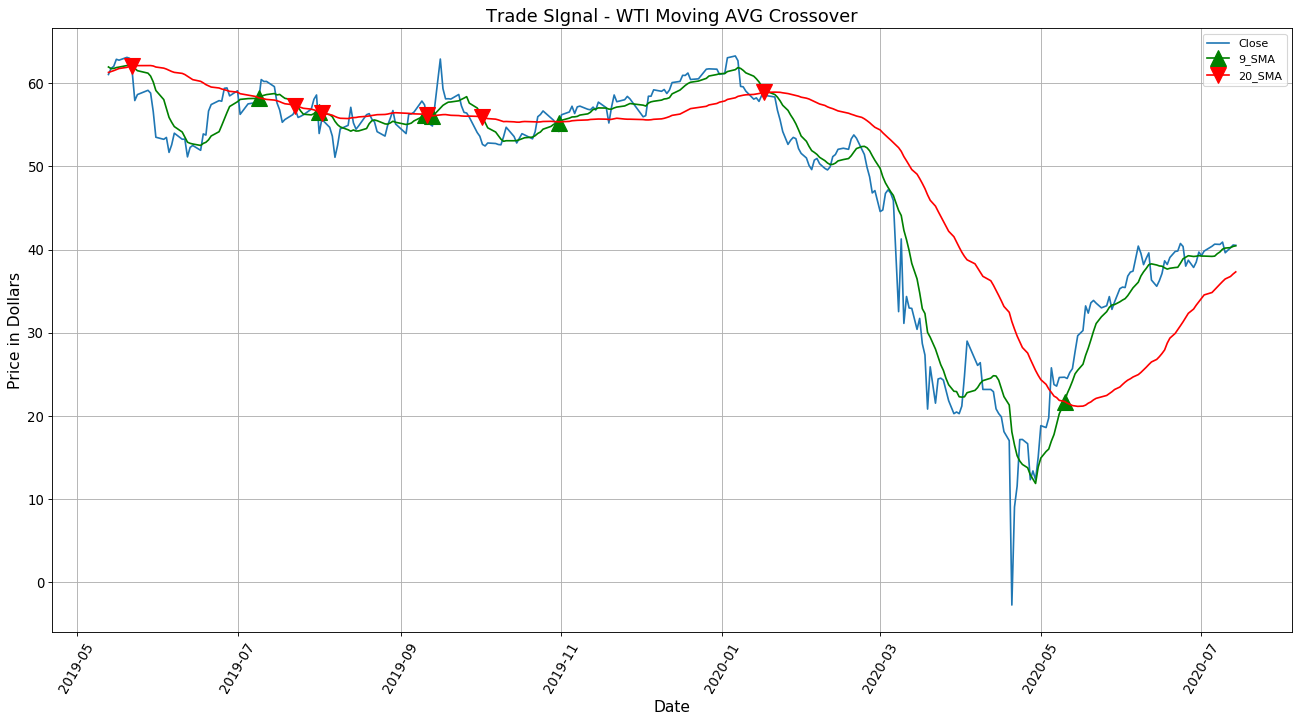

In [79]:
plts.figure(figsize=(20, 10),dpi=80)
plts.plot(wti_data.index, wti_data['Close'])
plts.plot(wti_data.index, wti_data['9_SMA'],'-^', markevery=Trade_Entry, ms=15, color='green')
plts.plot(wti_data.index, wti_data['20_SMA'],'-v', markevery=Trade_Exit, ms=15, color='red')
plts.xlabel('Date',fontsize=14)
plts.ylabel('Price in Dollars', fontsize = 14)
plts.xticks(rotation='60',fontsize=12)
plts.yticks(fontsize=12)
plts.title('Trade SIgnal - WTI Moving AVG Crossover', fontsize = 16)
plts.legend(['Close','9_SMA','20_SMA'])
plts.grid()
plts.show()

In [80]:
#NEWS TRADING STRATEGY 
# News API
url = 'https://newsapi.org/v2/everything?'

# Parameters
parameters = {
    'q': 'WTI', # query phrase
    'sortBy': 'popularity', # articles from popular sources and publishers come first
    'pageSize': 100,  # maximum is 100 for developer version
    'apiKey': '41f82539f4ec4ba79932a9ce234f115a', # your own API key
}

# API request
response = requests.get(url, params=parameters)

# Convert the response to JSON format and store it in dataframe
data = pd.DataFrame(response.json())

news_df = pd.concat([data['articles'].apply(pd.Series)], axis=1)

wti_news = news_df.loc[:,['publishedAt','title']]
wti_news['publishedAt'] = pd.to_datetime(wti_news['publishedAt'])
wti_news.sort_values(by='publishedAt',inplace=True)

# Business day dates
from pandas.tseries.offsets import BDay
# to get the business day for which particular news headline should be used to make trade signals
def get_trade_open(date):
    curr_date_open = pd.to_datetime(date).floor('d').replace(hour=13,minute=30) - BDay(0)
    curr_date_close = pd.to_datetime(date).floor('d').replace(hour=20,minute=0) - BDay(0)
    
    prev_date_close = (curr_date_open - BDay()).replace(hour=20,minute=0)
    next_date_open = (curr_date_close + BDay()).replace(hour=13,minute=30)
    
    if ((pd.to_datetime(date)>=prev_date_close) & (pd.to_datetime(date)<curr_date_open)):
        return curr_date_open
    elif ((pd.to_datetime(date)>=curr_date_close) & (pd.to_datetime(date)<next_date_open)):
        return next_date_open
    else:
        return None
      
 # Trading time for news headlines
wti_news["trading_time"] = wti_news["publishedAt"].apply(get_trade_open)

wti_news = wti_news[pd.notnull(wti_news['trading_time'])]
wti_news['Date'] = pd.to_datetime(pd.to_datetime(wti_news['trading_time']).dt.date)

In [81]:
#NLTK Imports
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [82]:
cs = []
for row in range(len(wti_news)):
    cs.append(analyzer.polarity_scores(wti_news['title'].iloc[row])['compound'])

wti_news['compound_vader_score'] = cs
wti_news = wti_news[(wti_news[['compound_vader_score']] != 0).all(axis=1)].reset_index(drop=True)

wti_news.tail()

,publishedAt,title,trading_time,Date,compound_vader_score
51,2020-07-10 12:15:14+00:00,Futures Movers: Oil prices slide as IEA warns ...,2020-07-10 13:30:00+00:00,2020-07-10,-0.7351
52,2020-07-14 02:18:00+00:00,Oil prices drop on demand recovery fears amid ...,2020-07-14 13:30:00+00:00,2020-07-14,-0.6597
53,2020-07-14 02:24:00+00:00,Oil prices drop on demand recovery fears amid ...,2020-07-14 13:30:00+00:00,2020-07-14,-0.6597
54,2020-07-14 02:52:00+00:00,Oil prices drop on demand recovery fears amid ...,2020-07-14 13:30:00+00:00,2020-07-14,-0.6597
55,2020-07-14 04:48:00+00:00,UPDATE 1-Oil prices drop on demand recovery fe...,2020-07-14 13:30:00+00:00,2020-07-14,-0.5267


In [83]:
unique_dates = wti_news['Date'].unique()
grouped_dates = wti_news.groupby(['Date'])
keys_dates = list(grouped_dates.groups.keys())

max_cs = []
min_cs = []

for key in grouped_dates.groups.keys():
    data = grouped_dates.get_group(key)
    if data["compound_vader_score"].max() > 0:
        max_cs.append(data["compound_vader_score"].max())
    elif data["compound_vader_score"].max() < 0:
        max_cs.append(0)
    
    if data["compound_vader_score"].min() < 0:
        min_cs.append(data["compound_vader_score"].min())
    elif data["compound_vader_score"].min() > 0:
        min_cs.append(0)
    
vader_scores_dict = {'Date':keys_dates,'max_scores':max_cs,'min_scores':min_cs}
vader_scores_df = pd.DataFrame(vader_scores_dict)

In [84]:
final_scores = []
for i in range(len(vader_scores_df)):
    final_scores.append(vader_scores_df['max_scores'].values[i] + vader_scores_df['min_scores'].values[i])

vader_scores_df['final_scores'] = final_scores

vader_scores_df.head()

,Date,max_scores,min_scores,final_scores
0,2020-06-18,0.0258,-0.6705,-0.6447
1,2020-06-19,0.7506,0.0000,0.7506
2,2020-06-24,0.0000,-0.5994,-0.5994
3,2020-06-25,0.0000,-0.7906,-0.7906
4,2020-06-26,0.3818,-0.7684,-0.3866


In [99]:
# VADER trade Signal
vader_entry=[]
vader_exit=[]
for i in range(len(vader_scores_df)):
    if vader_scores_df['final_scores'].values[i] > 0.20:
        print("Trade Call for {row} is Entry.".format(row=vader_scores_df['Date'].iloc[i].date()))
        vader_entry.append(vader_scores_df['Date'].iloc[i].date())
    elif vader_scores_df['final_scores'].values[i] < -0.20:
        print("Trade Call for {row} is Exit.".format(row=vader_scores_df['Date'].iloc[i].date()))
        vader_exit.append(vader_scores_df['Date'].iloc[i].date())

Trade Call for 2020-06-18 is Exit.
Trade Call for 2020-06-19 is Entry.
Trade Call for 2020-06-24 is Exit.
Trade Call for 2020-06-25 is Exit.
Trade Call for 2020-06-26 is Exit.
Trade Call for 2020-06-30 is Exit.
Trade Call for 2020-07-02 is Exit.
Trade Call for 2020-07-03 is Exit.
Trade Call for 2020-07-07 is Entry.
Trade Call for 2020-07-09 is Exit.
Trade Call for 2020-07-10 is Exit.
Trade Call for 2020-07-14 is Exit.


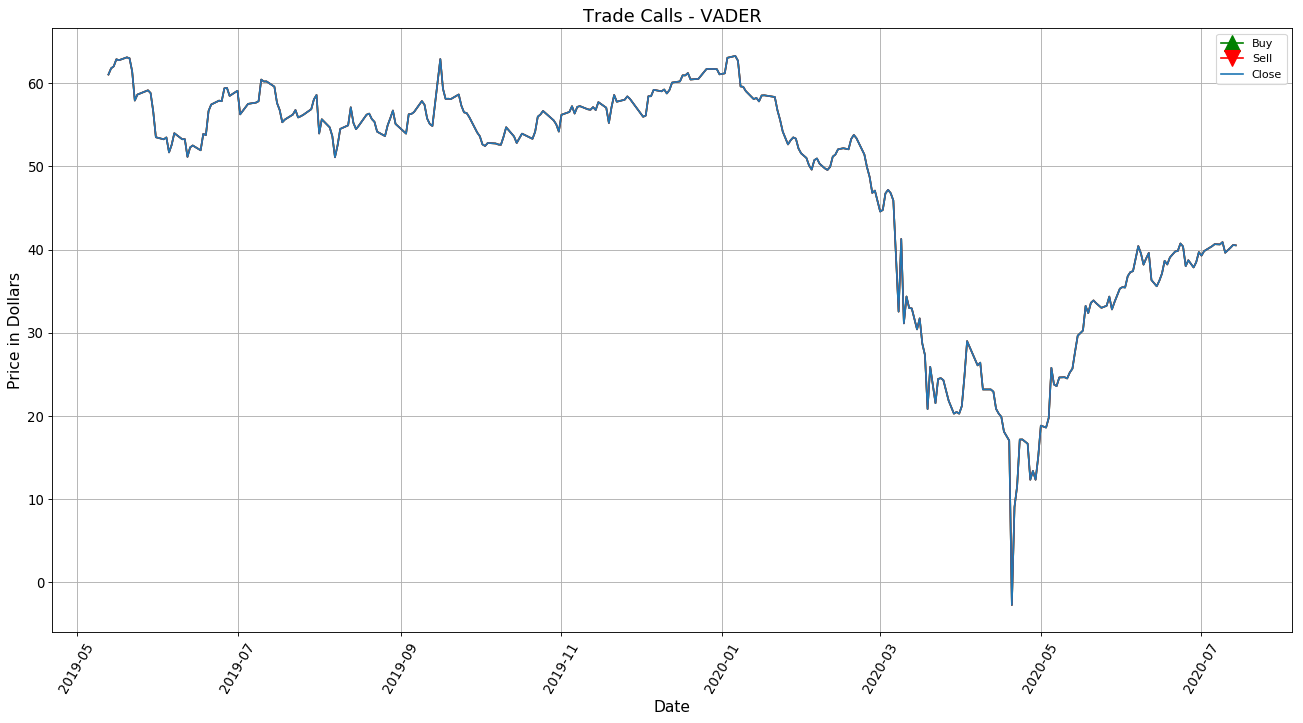

In [102]:
vader_entry = []
for i in range(len(oil_data)):
    if wti_data.index[i].date() in vader_entry:
        vader_entry.append(i)
        
vader_exit = []
for i in range(len(wti_data)):
    if wti_data.index[i].date() in vader_exit:
        vader_exit.append(i)
        
plts.figure(figsize=(20, 10),dpi=80)
plts.plot(wti_data.index, wti_data['Close'],'-^', markevery=vader_entry, ms=15, color='green')
plts.plot(wti_data.index, wti_data['Close'],'-v', markevery=vader_exit, ms=15, color='red')
plts.plot(wti_data.index, wti_data['Close'])
plts.xlabel('Date',fontsize=14)
plts.ylabel('Price in Dollars', fontsize = 14)
plts.xticks(rotation='60',fontsize=12)
plts.yticks(fontsize=12)
plts.title('Trade Calls - VADER', fontsize = 16)
plts.legend(['Buy','Sell','Close'])
plts.grid()
plts.show()

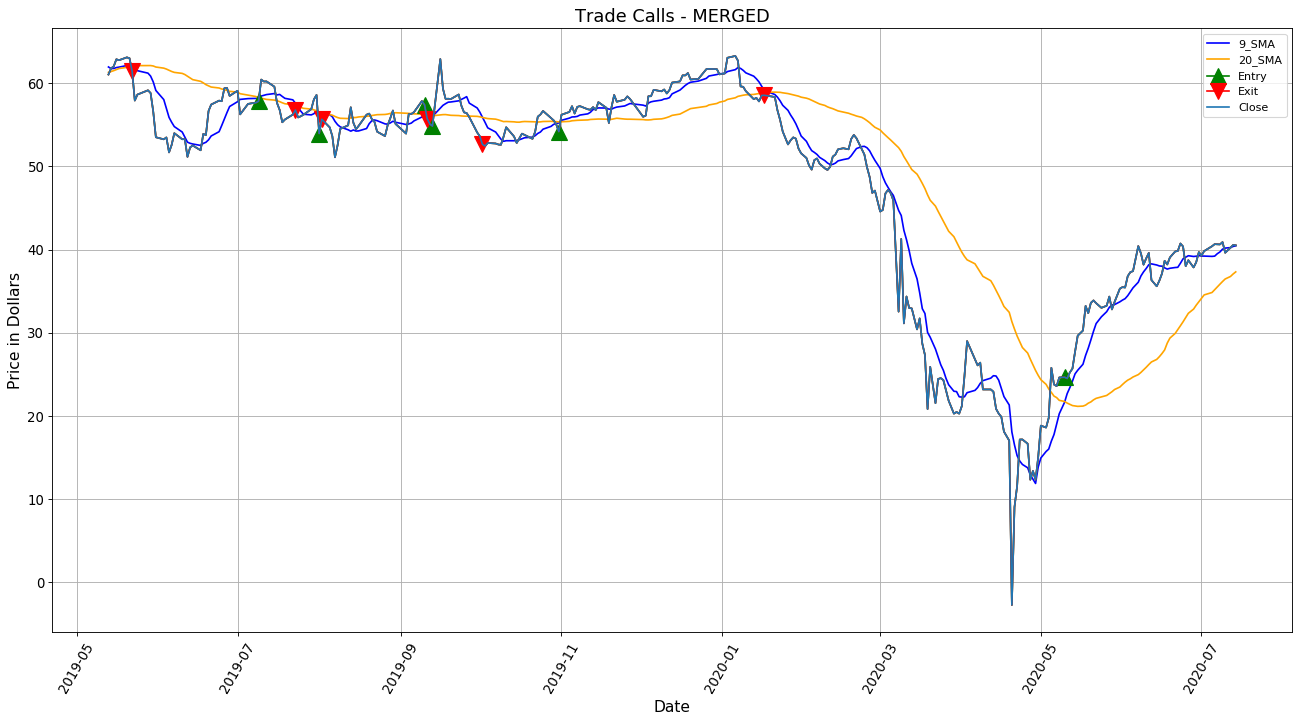

In [101]:
#SMA signals
final_entry = list(set(Trade_Entry + vader_entry) - set(Trade_Exit)) 
final_exit = list(set(Trade_Exit + vader_exit) - set(Trade_Entry))

plt.figure(figsize=(20, 10),dpi=80)
plt.plot(wti_data.index, wti_data['9_SMA'], color='blue')
plt.plot(wti_data.index, wti_data['20_SMA'], color='orange')
plt.plot(wti_data.index, wti_data['Close'],'-^', markevery=final_entry, ms=15, color='green')
plt.plot(wti_data.index, wti_data['Close'],'-v', markevery=final_exit, ms=15, color='red')
plt.plot(wti_data.index, wti_data['Close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - MERGED', fontsize = 16)
plt.legend(['9_SMA','20_SMA','Entry','Exit','Close'])
plt.grid()
plt.show()